## BBM409 Introduction to Machine Learning Lab.  Fall 2022.
# Assignment 3

### Contributors:

### Ali Argun Sayilgan   : 21827775
### Mehmet Giray Nacakci :  21989009

## Please run this report with   "RUN ALL" command

### It takes around 40 seconds to get all the results.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from collections import Counter, OrderedDict
from operator import itemgetter
import pandas as pd
pd.set_option('display.precision', 2)
import numpy as np
import math
import time

## Classification of News Articles

The Dataset consists of 1490 English News Articles, each belonging to one of the 5 categories (Sport, Business, Politics, Entertainment, Tech).
We implemented the Naive Bayes Classifier Algorithm to predict categories of Articles.

In [ ]:
df = pd.read_csv("English Dataset.csv")
accuracies = []

display(df.head(8))
display(df.Category.value_counts())

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
5,1582,howard truanted to play snooker conservative...,politics
6,651,wales silent on grand slam talk rhys williams ...,sport
7,1797,french honour for director parker british film...,entertainment


sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

Dataset is balanced, all categories have similar amount of samples. This is expected to cause less/no bias in ml models' predictions.

# PART 1: Understanding the data

Using Count Vectorizer, displaying most commonly occurring words for each category,
and guessing what words could be an important factor in classification for each category.

In this part, we temporarily cleaned-up the dataset from stop words to see actual categorically significant words.

In [ ]:
categories = ["sport", "business", "politics", "entertainment", "tech"]
for category in categories:
    subset = df[df['Category'] == category]

    vectorizer = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)

    word_counts_for_each_sample = vectorizer.fit_transform(subset["Text"].to_numpy())
    word_counts_in_total = np.sum(word_counts_for_each_sample, axis=0).tolist()

    words_list = vectorizer.get_feature_names_out()
    most_frequent_words_indices = np.flip(np.argsort(word_counts_in_total)[0])
    most_frequent_words = []
    count_ = 0

    for i in most_frequent_words_indices:

        this_word = words_list[i]
        most_frequent_words.append(this_word + " : " + str(word_counts_in_total[0][i]))
        count_ += 1

        if count_ > 25:
            break

    print("Most common 25 words in  " + category.upper() + "  category are: \n       " + str(most_frequent_words) + "\n")


Most common 25 words in  SPORT  category are: 
       ['said : 636', 'game : 356', 'year : 331', 'england : 329', 'time : 296', 'win : 295', 'world : 269', 'players : 209', 'cup : 206', 'team : 205', 'new : 202', 'ireland : 194', 'half : 194', 'play : 193', 'just : 192', 'second : 189', 'wales : 183', 'match : 180', 'final : 180', 'won : 175', 'good : 170', 'season : 166', 'set : 161', 'france : 158', 'chelsea : 157', 'coach : 150']

Most common 25 words in  BUSINESS  category are: 
       ['said : 1100', 'year : 456', 'mr : 393', 'market : 284', 'new : 273', 'firm : 261', 'growth : 257', 'company : 253', 'economy : 233', 'government : 215', 'bank : 206', 'economic : 202', 'sales : 201', '2004 : 199', 'oil : 179', '000 : 175', 'shares : 171', 'world : 169', 'years : 162', 'chief : 156', 'business : 155', 'deal : 152', 'uk : 149', 'china : 140', 'financial : 140', 'companies : 140']

Most common 25 words in  POLITICS  category are: 
       ['said : 1445', 'mr : 1073', 'labour : 494', 'g

From the results, for each category, the most relevant (frequent) words (likely have a role in classification) we think are:

SPORT:  game, players, cup, team, season, match, play
BUSINESS: market, growth, company, business, financial, companies, economic
POLITICS: labour, government, election, party, leader, minister
ENTERTAINMENT: film, music, awards, actor, director, album
TECH: mobile, technology, software, digital, computer, online

This list is based on the dataset and result is intuitive since these words are the natural vocabulary of the five specific topics.
Therefore, using Naive Bayes Algorithm will be feasible to classify articles based on frequently occurring words.

In next chapters we will examine if these really are the words that guide the classification.

# PART 2: Implementing Naive Bayes

#### Data Clean-up

Dataset consists of unrelated numerical strings and clutter such as '000', '05', '10', 'a100', '100m', '10m'.
These terms should be completely removed from the dataset, as they do not make sense for category-related classification.

In [ ]:
def data_cleanup(dataset_x):
    # Remove terms that are not mostly consisting of alphabetical characters
    for r in range(len(dataset_x)):
        document_ = dataset_x[r]
        row_words = document_.split()
        filtered_document = []
        for a_word in row_words:
            letter_character_count = sum(char_.isalpha() for char_ in a_word)

            if letter_character_count > len(a_word)//2:
                filtered_document.append(a_word)

        dataset_x[r] = " ".join(filtered_document)
    return dataset_x

#### Dataset Split
##### (80% Train, 20% Test)

In [ ]:
# 1490 samples
X = df.Text
Y = df.Category

X = X.to_numpy()
X = data_cleanup(X)
Y = Y.to_numpy()

# shuffle the dataset, then split as 80% Train and 20% Test.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=24, shuffle=True, stratify=Y)
# stratify: keeps the proportion of classes (compared to each other) stable, while splitting the dataset.


### TRAINING  (Creating Vocabularies from Training Articles)

Text vectorization: Articles are turned into n-feature vectors. n is the articles' split to terms.

Bag of Words (BoW) model learns occurrences (counts, frequencies) of each term in documents, then total for each category.
<br/>

#### "Term" can be:
   * #### Unigram: individual Word
   * #### Bigram:  two adjacent words

Terms are then mapped (dictionary creation) to their frequencies, creating Vocabularies for each category.

In [ ]:
category_frequencies = pd.Series(y_train).value_counts().to_dict()
categories = list(category_frequencies.keys())

""" UNIGRAM : Creating UNIGRAM Dictionaries: The frequencies of individual words in documents. """

dictionaries_unigram = []
for category in categories:

    subset = X_train[np.where(y_train == category)]
    vectorizer = CountVectorizer()
    word_counts_for_each_sample = vectorizer.fit_transform(subset)
    word_counts_in_total = np.sum(word_counts_for_each_sample, axis=0).tolist()
    words_list = vectorizer.get_feature_names_out()

    word_to_count_dictionary = {}
    for n in range(len(words_list)):
        word_to_count_dictionary[words_list[n]] = word_counts_in_total[0][n]

    dictionaries_unigram.append(word_to_count_dictionary)


""" BIGRAM: Creating BIGRAM Dictionaries: The frequencies of two adjacent words in documents. """

dictionaries_bigram = []
for category in categories:

    subset = X_train[np.where(y_train == category)]
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
    bigram_counts_for_each_sample = vectorizer.fit_transform(subset)
    bigram_counts_in_total = np.sum(bigram_counts_for_each_sample, axis=0).tolist()
    bigrams_list = vectorizer.get_feature_names_out()

    bigram_to_count_dictionary = {}
    for n in range(len(bigrams_list)):
        bigram_to_count_dictionary[bigrams_list[n]] = bigram_counts_in_total[0][n]

    dictionaries_bigram.append(bigram_to_count_dictionary)


## Naive Bayes Classification

General formula of Naive Bayes Classifier:
<br/>

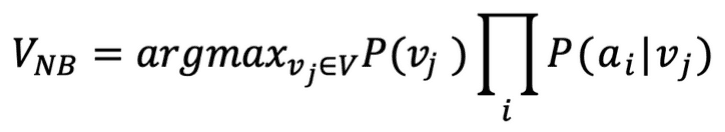
<br/>

where vj is the set of 5 Categories (labels), and ai are other attributes (each term in vocabulary)
<br/>
To Classify a test sample to a one of the 5 categories, we will compare conditional probability chains that lead to those 5 categories for this sample.
The bigger probability one wins. The individual probability terms in calculations (ratios of existence) are inferred from Vocabularies created in Training.
<br/>

    Suppose we have a Test sample.  Article = "This musician created an album after the election yeah election music election ... "

General formula for probability of a sample belonging to a class(category):

    P(this test sample is entertainment) = p(entertainment) *  for each feature: { p(probability of this feature | entertainment) }

For term (word or bigram) frequency:

    P(this test sample is entertainment) = p(entertainment) *  for each [unique or not] term: { p(probability of this term | in entertainment) }

For preventing Floating Point Underflow:

    P(this test sample is entertainment) = log[p(entertainment)] +  for each [unique or not] term: { log [ p(probability of this term | in entertainment) ] }

We will be using the third, sum of LOGs formula in our calculations.


<br/>

### Two alternatives are implemented and compared:

* ### NON-UNIQUE:
#### Looping over (calculating and summing up) Probability for EACH Term in a Test sample one-by-one.
##### This way, a Term appears more frequently in the Test sample has more affect than another one that appears once.
<br/>

* ### UNIQUE:
#### Looping over not EACH but Each UNIQUE Terms in a Test sample.


In [ ]:
def find_probability_of_word_or_bigram_in_category(category_index_, word_or_bigram, vocabulary):

    frequency_ = 0

    if word_or_bigram in vocabulary.keys():
        frequency_ = vocabulary.get(word_or_bigram)

    # Laplace Smoothing:  prevent zero probability
    return (frequency_ + 1) / (category_frequencies.get(categories[category_index_]) + 5)  # 5 is for 5 categories


def accuracy(predictions_, ground_truths_):
    return sum(np.array(predictions_) == np.array(ground_truths_)) / len(predictions_)


def classify_test_set_samples(is_bigram, is_for_unique, vocabulary_dictionaries):

    predictions = []
    actual_categories = []
    start = time.time()

    for p, this_sample in enumerate(X_test):

        probabilities_of_this_sample_for_each_category = []  # best one wins classification
        for c, category_ in enumerate(categories):

            # initially, prior probability  P(this category's probability itself)
            prob_of_being_this_category = category_frequencies.get(category_) / len(y_train)


            """ posterior probabilities """

            words_ = this_sample.split()
            terms_ = words_

            if is_bigram:
                bigrams_ = [words_[q] + " " + words_[q+1] for q in range(len(words_) - 1)]
                terms_ = bigrams_

            if is_for_unique:
                terms_ = np.unique(terms_)
                """
                NON-UNIQUE: Looping over (calculating and summing up) Probability for EACH Term in Test sample one-by-one.
                    This way, a Term appears more frequently has more affect than another one that appears once.
                UNIQUE: Looping over not EACH but Each UNIQUE Terms in Test sample.
                """

            for term_ in terms_:
                prob_of_being_this_category += math.log(find_probability_of_word_or_bigram_in_category(c, term_, vocabulary_dictionaries[c]))

            probabilities_of_this_sample_for_each_category.append(prob_of_being_this_category)

        predicted_category_of_this_sample = categories[np.argmax(probabilities_of_this_sample_for_each_category)]
        predictions.append(predicted_category_of_this_sample)
        actual_categories.append(y_test[p])


    print(str(len(X_test))  + "  samples predicted  in  ", end=" ")
    print('%d  seconds \n' %(time.time()-start))
    print("Predicted:  " + str(OrderedDict(sorted(Counter(predictions).items()))))
    print("Actual:  :  " + str(OrderedDict(sorted(Counter(actual_categories).items()))))
    accuracy_ = accuracy(predictions, actual_categories)
    print("\n ACCURACY:  " + str(round(accuracy_, 3)) + "\n")
    return accuracy_


def classify_all(unigram_vocabulary, bigram_vocabulary):
    """ Classify Test set with All model variations, using inputted Vocabularies """

    print("UNIGRAM   --------- --   UNIGRAM   ------- ----   UNIGRAM   ------------   UNIGRAM   ------------   UNIGRAM   -----\n")
    print("- - - -  UNIGRAMS.  NON-UNIQUE Test Terms  - - - -\n")
    accuracies.append(classify_test_set_samples(False, False, unigram_vocabulary))
    print("- - - -  UNIGRAMS.  UNIQUE Test Terms  - - - -\n")
    accuracies.append(classify_test_set_samples(False, True, unigram_vocabulary))

    print("\nBIGRAM   -------------   BIGRAM   -------------   BIGRAM   -------------   BIGRAM   -------------   BIGRAM   ----\n")
    print("- - - -  BIGRAMS.  NON-UNIQUE Test Terms  - - - -\n")
    accuracies.append(classify_test_set_samples(True, False, bigram_vocabulary))
    print("- - - -  BIGRAMS.  UNIQUE Test Terms - - - -\n")
    accuracies.append(classify_test_set_samples(True, True, bigram_vocabulary))


#### UNIGRAM & BIGRAM Classification Results

In [ ]:
classify_all(dictionaries_unigram, dictionaries_bigram)

UNIGRAM   --------- --   UNIGRAM   ------- ----   UNIGRAM   ------------   UNIGRAM   ------------   UNIGRAM   -----

- - - -  UNIGRAMS.  NON-UNIQUE Test Terms  - - - -

298  samples predicted  in   0  seconds 

Predicted:  OrderedDict([('business', 41), ('entertainment', 31), ('politics', 70), ('sport', 63), ('tech', 93)])
Actual:  :  OrderedDict([('business', 67), ('entertainment', 55), ('politics', 55), ('sport', 69), ('tech', 52)])

 ACCURACY:  0.809

- - - -  UNIGRAMS.  UNIQUE Test Terms  - - - -

298  samples predicted  in   0  seconds 

Predicted:  OrderedDict([('business', 45), ('entertainment', 32), ('politics', 69), ('sport', 66), ('tech', 86)])
Actual:  :  OrderedDict([('business', 67), ('entertainment', 55), ('politics', 55), ('sport', 69), ('tech', 52)])

 ACCURACY:  0.836


BIGRAM   -------------   BIGRAM   -------------   BIGRAM   -------------   BIGRAM   -------------   BIGRAM   ----

- - - -  BIGRAMS.  NON-UNIQUE Test Terms  - - - -

298  samples predicted  in   0  seco

We were actually expecting Bigrams to perform better than Unigrams, since a category specific word couple such as "music industry" could be more related to Entertainment category than just "music" or "industry". Yet, Unigrams seem to perform about 10% better than Bigrams.

It seems that all vocabulary variations seem to favor predicting Tech and Politics more than other categories.

# PART 3

# PART 3 : A
## First Objective: Analyzing the strongest and weakest Terms
## in terms of their effect on prediction

Considering Naive Bayes classification:

    P(this test sample is entertainment) = p(entertainment) *  for each [unique or not] term: { p(probability of this term | in entertainment) }

This posterior probability is determined from previous events (training data). Since a Training Dictionary Term has as much effect as it's occurrence (frequency), we will directly analyse TF-IDF (Term Frequency - Inverse Document Frequency)(or Relevance) measure for each word in training vocabulary.

Then, we will display the most and least effective/significant words of each article category.


#### Term Frequency:
Occurrence ratio of this term (word or bigram) in this Category (article, sample). Similar to our find_probability_of_word_or_bigram_in_category( ) function.
    = log ( 1  +  this term's occurrence in this category / total terms in this category )
<br/>

#### Inverse Document Frequency:
is a measure related to "How many categories contain this term?, How special is it?". If this term appears in many categories, it is probably not that category-specific and cannot help much in classification.  For example, IDF = 0  if this term is contained in all documents.
    = log (all categories / categories that contain this term)
<br/>

#### And TD-IDF
is calculated as the product of the two:   TF * IDF.
High score means this word is relevant to this category. How important is this word for this category, in the context of the whole collection?



In [ ]:

""" UNIGRAM """

tfidf_for_unigrams_in_categories = []

for m, dictionary_ in enumerate(dictionaries_unigram):

    this_category_words_to_tfidf_s = {}

    for word_ in dictionary_.keys():
        term_frequency = dictionary_.get(word_) / category_frequencies.get(categories[m])

        how_many_categories_contain_this_term = 0
        for a_category_dictionary_ in dictionaries_unigram:
            if word_ in a_category_dictionary_.keys():
                how_many_categories_contain_this_term += 1
        inverse_document_frequency = math.log(5 / how_many_categories_contain_this_term)

        tf_idf = term_frequency * inverse_document_frequency
        this_category_words_to_tfidf_s[word_] = tf_idf

    tfidf_for_unigrams_in_categories.append(this_category_words_to_tfidf_s)


    print("\nCategory:  " + categories[m].upper())

    # highest TF-IDF values
    most_effective_10_words = dict(sorted(this_category_words_to_tfidf_s.items(), key = itemgetter(1), reverse = True)[:10]).keys()
    print("  10 Most effective Words: \n    " + str(most_effective_10_words))

    # lowest TF-IDF values
    least_effective_10_words = dict(sorted(this_category_words_to_tfidf_s.items(), key = itemgetter(1))[:10]).keys()
    print("  10 Least effective Words: \n    " + str(least_effective_10_words))



""" BIGRAM """

tfidf_for_bigrams_in_categories = []

for m, dictionary_ in enumerate(dictionaries_bigram):

    this_category_bigrams_to_tfidf_s = {}

    for bigram_ in dictionary_.keys():
        term_frequency = dictionary_.get(bigram_) / category_frequencies.get(categories[m])

        how_many_categories_contain_this_term = 0
        for a_category_dictionary_ in dictionaries_bigram:
            if bigram_ in a_category_dictionary_.keys():
                how_many_categories_contain_this_term += 1
        inverse_document_frequency = math.log(5 / how_many_categories_contain_this_term)

        tf_idf = term_frequency * inverse_document_frequency
        this_category_bigrams_to_tfidf_s[bigram_] = tf_idf

    tfidf_for_bigrams_in_categories.append(this_category_bigrams_to_tfidf_s)


    print("\nCategory:  " + categories[m].upper())

    # highest TF-IDF values
    most_effective_10_bigrams = dict(sorted(this_category_bigrams_to_tfidf_s.items(), key = itemgetter(1), reverse = True)[:10]).keys()
    print("  10 Most effective BIGRAMs: \n    " + str(most_effective_10_bigrams))

    # lowest TF-IDF values
    least_effective_10_bigrams = dict(sorted(this_category_bigrams_to_tfidf_s.items(), key = itemgetter(1))[:10]).keys()
    print("  10 Least effective BIGRAMs: \n    " + str(least_effective_10_bigrams))



Category:  SPORT
  10 Most effective Words: 
    dict_keys(['roddick', 'chelsea', 'coach', 'nadal', 'referee', 'athens', 'arsenal', 'tennis', 'championships', 'slam'])
  10 Least effective Words: 
    dict_keys(['10', '30', 'ability', 'able', 'about', 'above', 'absolute', 'absolutely', 'accept', 'acceptable'])

Category:  BUSINESS
  10 Most effective Words: 
    dict_keys(['yukos', 'economy', 'lse', 'imf', 'deficit', 'gm', 'worldcom', 'ebbers', 'market', 'boerse'])
  10 Least effective Words: 
    dict_keys(['10', '30', 'ability', 'able', 'about', 'above', 'absolute', 'absolutely', 'accept', 'acceptable'])

Category:  POLITICS
  10 Most effective Words: 
    dict_keys(['tory', 'tories', 'kilroy', 'ukip', 'lib', 'lords', 'chancellor', 'asylum', 'labour', 'mps'])
  10 Least effective Words: 
    dict_keys(['10', '30', 'ability', 'able', 'about', 'above', 'absolute', 'absolutely', 'accept', 'acceptable'])

Category:  ENTERTAINMENT
  10 Most effective Words: 
    dict_keys(['album', 'actr

As observed, most effective terms are closely/uniquely related to the topics of these categories, whereas least effective terms (most of them are stop words) are mostly common between categories, and can be related to anything.

We can observe common terms between this part and our most frequent (or relevant in prediction) words guesses from Part 1.
Such as:  "chelsea", "coach", "the match" in Sport category;
'the software', 'digital cameras', 'mobiles' in Tech category,
'album', 'the film', 'awards' in Entertainment category, and so on.

Yet, since the most effective words are not necessarily the most frequent words, common terms are not many.
That is why frequency is not directly equal to relevance. Uniqueness of a word in a category should be rewarded.


# PART 3 : A
# Second Objective: Narrowing Down Dictionaries (Eliminating non-effective vocabulary)

##### Let us narrow down our vocabularies to  only the most effective portion of the vocabulary, and see if classification results improve.
The most effective portion is the portion consisting of highest TD-IDF Terms (calculated in previous section).

In [ ]:

def narrow_down_dictionaries(narrowing_percentage):

    """ UNIGRAM """
    narrowed_unigram_dictionaries = []

    for category_index, category_tfidf_s in enumerate(tfidf_for_unigrams_in_categories):
        len_remaining = math.floor(len(category_tfidf_s) * ((100-narrowing_percentage)/100))
        most_effective_part = dict(sorted(category_tfidf_s.items(), key = itemgetter(1), reverse = True)[:len_remaining])

        word_to_count_dictionary_ = {}
        for word in most_effective_part.keys():
            word_to_count_dictionary_[word] = dictionaries_unigram[category_index].get(word)
        narrowed_unigram_dictionaries.append(word_to_count_dictionary_)


    """ BIGRAM """
    narrowed_bigram_dictionaries = []

    for category_index, category_tfidf_s in enumerate(tfidf_for_bigrams_in_categories):
        len_remaining = math.floor(len(category_tfidf_s) * ((100-narrowing_percentage)/100))
        most_effective_part = dict(sorted(category_tfidf_s.items(), key = itemgetter(1), reverse = True)[:len_remaining])

        bigram_to_count_dictionary_ = {}
        for bigram__ in most_effective_part.keys():
            bigram_to_count_dictionary_[bigram__] = dictionaries_bigram[category_index].get(bigram__)
        narrowed_bigram_dictionaries.append(bigram_to_count_dictionary_)

    return narrowed_unigram_dictionaries, narrowed_bigram_dictionaries

#### Classification with 20% Narrowed-Down Dictionaries

In [ ]:
classify_all(*narrow_down_dictionaries(20))

UNIGRAM   --------- --   UNIGRAM   ------- ----   UNIGRAM   ------------   UNIGRAM   ------------   UNIGRAM   -----

- - - -  UNIGRAMS.  NON-UNIQUE Test Terms  - - - -

298  samples predicted  in   0  seconds 

Predicted:  OrderedDict([('business', 29), ('entertainment', 46), ('politics', 120), ('sport', 50), ('tech', 53)])
Actual:  :  OrderedDict([('business', 67), ('entertainment', 55), ('politics', 55), ('sport', 69), ('tech', 52)])

 ACCURACY:  0.762

- - - -  UNIGRAMS.  UNIQUE Test Terms  - - - -

298  samples predicted  in   0  seconds 

Predicted:  OrderedDict([('business', 36), ('entertainment', 43), ('politics', 109), ('sport', 58), ('tech', 52)])
Actual:  :  OrderedDict([('business', 67), ('entertainment', 55), ('politics', 55), ('sport', 69), ('tech', 52)])

 ACCURACY:  0.809


BIGRAM   -------------   BIGRAM   -------------   BIGRAM   -------------   BIGRAM   -------------   BIGRAM   ----

- - - -  BIGRAMS.  NON-UNIQUE Test Terms  - - - -

298  samples predicted  in   0  se

As it is observed, narrowing-down by 20% is too much. Accuracies of all models are dropped by around 2.5%. We actually desire an increase in accuracy.

Apparently, we removed too many actually useful terms. Insignificant terms were not covering such a big portion of the vocabularies.

Let us try only 5%.

#### Classification with 5% Narrowed-Down Dictionaries

In [ ]:
classify_all(*narrow_down_dictionaries(5))

UNIGRAM   --------- --   UNIGRAM   ------- ----   UNIGRAM   ------------   UNIGRAM   ------------   UNIGRAM   -----

- - - -  UNIGRAMS.  NON-UNIQUE Test Terms  - - - -

298  samples predicted  in   0  seconds 

Predicted:  OrderedDict([('business', 44), ('entertainment', 33), ('politics', 74), ('sport', 63), ('tech', 84)])
Actual:  :  OrderedDict([('business', 67), ('entertainment', 55), ('politics', 55), ('sport', 69), ('tech', 52)])

 ACCURACY:  0.829

- - - -  UNIGRAMS.  UNIQUE Test Terms  - - - -

298  samples predicted  in   0  seconds 

Predicted:  OrderedDict([('business', 47), ('entertainment', 34), ('politics', 77), ('sport', 64), ('tech', 76)])
Actual:  :  OrderedDict([('business', 67), ('entertainment', 55), ('politics', 55), ('sport', 69), ('tech', 52)])

 ACCURACY:  0.842


BIGRAM   -------------   BIGRAM   -------------   BIGRAM   -------------   BIGRAM   -------------   BIGRAM   ----

- - - -  BIGRAMS.  NON-UNIQUE Test Terms  - - - -

298  samples predicted  in   0  seco

As it is observed, narrowing-down by 5%  increased accuracies of Unigram models by around 2%, whereas it decreased accuracies of Bigram models by around 2%.

We can safely say that, around 5% of the old vocabulary Unigrams were insignificant/non-useful (and in fact overfitting) for classification.

Yet, for Bigrams, we still seem to be eliminating too many. We should not have seen a decrease in accuracy. Let us try narrowing with only 2%.


#### Classification with 2% Narrowed-Down Dictionaries

In [ ]:
classify_all(*narrow_down_dictionaries(2))

UNIGRAM   --------- --   UNIGRAM   ------- ----   UNIGRAM   ------------   UNIGRAM   ------------   UNIGRAM   -----

- - - -  UNIGRAMS.  NON-UNIQUE Test Terms  - - - -

298  samples predicted  in   0  seconds 

Predicted:  OrderedDict([('business', 41), ('entertainment', 33), ('politics', 69), ('sport', 62), ('tech', 93)])
Actual:  :  OrderedDict([('business', 67), ('entertainment', 55), ('politics', 55), ('sport', 69), ('tech', 52)])

 ACCURACY:  0.812

- - - -  UNIGRAMS.  UNIQUE Test Terms  - - - -

298  samples predicted  in   0  seconds 

Predicted:  OrderedDict([('business', 45), ('entertainment', 32), ('politics', 69), ('sport', 65), ('tech', 87)])
Actual:  :  OrderedDict([('business', 67), ('entertainment', 55), ('politics', 55), ('sport', 69), ('tech', 52)])

 ACCURACY:  0.832


BIGRAM   -------------   BIGRAM   -------------   BIGRAM   -------------   BIGRAM   -------------   BIGRAM   ----

- - - -  BIGRAMS.  NON-UNIQUE Test Terms  - - - -

298  samples predicted  in   0  seco

Compared to 5% narrowed version above, Accuracies of Unigram models are decreased by around 1%, yet Bigram has increased around 4%.

It seems that, only around 2% of Bigram vocabulary is insignificant/overfitting, not as much as 5%.

For Unigram Vocabulary, we observed that, definitely more than 2%, around 5%, definitely less than 20% of the Unigram vocabulary is insignificant.

One factor that effects all these Accuracy changes while narrowing-down the Dictionaries is how IDF is calculated.
There are different smoothing options in IDF.
We have chosen the most accurate option for our dataset after trying different options.

        inverse_document_frequency = math.log(  5    /  how_many_categories_contain_this_term )        --> our choice: no smoothing
        inverse_document_frequency = math.log(  5    / (how_many_categories_contain_this_term +1) )
        inverse_document_frequency = math.log( (5+1) / (how_many_categories_contain_this_term +1) )

With "no smoothing", the classification power of common words (especially stop-words) is reduced the most.

# PART 3 : B
# Removing Stop Words


### Listing the most effective Non-StopWords

In Part-3-A: First Objective:  We analyzed the strongest Terms in terms of their effect on prediction, by calculating TF-IDF for all terms.
Now, we will do the same most-effective listing, while excluding Unigrams and Bigrams that include stop-words.

In [ ]:
""" UNIGRAM """
for m, category_words_to_tfidf in enumerate(tfidf_for_unigrams_in_categories):

    print("Category:  " + categories[m].upper() + "    15 Most effective Non-Stop-WORDS:")

    tfidf_sorted_words = dict(sorted(category_words_to_tfidf.items(), key = itemgetter(1), reverse = True))
    most_effective_15_words = []
    k = 0
    for word_ in tfidf_sorted_words.keys():
        if word_ not in ENGLISH_STOP_WORDS:
            most_effective_15_words.append(word_)
            k += 1
        if k==14:
            break
    print(str(most_effective_15_words) + "\n")


""" BIGRAM """
for m, category_bigrams_to_tfidf in enumerate(tfidf_for_bigrams_in_categories):

    print("\nCategory:  " + categories[m].upper() + "    Most effective Non-Stop-BIGRAMs:")

    tfidf_sorted_bigrams = dict(sorted(category_bigrams_to_tfidf.items(), key = itemgetter(1), reverse = True))
    most_effective_bigrams = []
    k = 0
    for bigram_ in tfidf_sorted_bigrams.keys():
        bigram = bigram_.split()
        if (bigram[0] not in ENGLISH_STOP_WORDS) and (bigram[1] not in ENGLISH_STOP_WORDS):
            most_effective_bigrams.append(bigram_)
            k += 1
        if k==14:
            break
    print(most_effective_bigrams)

Category:  SPORT    15 Most effective Non-Stop-WORDS:
['roddick', 'chelsea', 'coach', 'nadal', 'referee', 'athens', 'arsenal', 'tennis', 'championships', 'slam', 'indoor', 'gara', 'wenger', 'mourinho']

Category:  BUSINESS    15 Most effective Non-Stop-WORDS:
['yukos', 'economy', 'lse', 'imf', 'deficit', 'gm', 'worldcom', 'ebbers', 'market', 'boerse', 'firms', 'securities', 'creditors', 'fiat']

Category:  POLITICS    15 Most effective Non-Stop-WORDS:
['tory', 'tories', 'kilroy', 'ukip', 'lib', 'lords', 'chancellor', 'asylum', 'labour', 'mps', 'election', 'immigration', 'tax', 'party']

Category:  ENTERTAINMENT    15 Most effective Non-Stop-WORDS:
['album', 'actress', 'festival', 'film', 'oscar', 'chart', 'aviator', 'awards', 'movie', 'comedy', 'elvis', 'theatre', 'oscars', 'nominated']

Category:  TECH    15 Most effective Non-Stop-WORDS:
['software', 'users', 'spam', 'microsoft', 'gadgets', 'mobiles', 'portable', 'bt', 'digital', 'consumers', 'viruses', 'blogs', 'xbox', 'p2p']


Cate

Since the most high-relevance Unigrams (words) were already non-stop words, we see no change in this part, from the Part-3-A.
This is expected, since stop words are common between all categories, reducing their IDF scores.

On the other hand, most effective non-stop-Bigrams in this, look very different from their Part-3-A counterparts.
It appears that, in our dataset, Bigrams that include stop words have higher TF-IDF scores than non-stop ones.
This is no big surprise, since in English, compound words and phrasal verbs has a major importance in conveying meaning.


### Removing Stop Words from Vocabulary

Create new dictionaries from old ones, excluding Unigrams or Bigrams that include stop-words.

In [ ]:
def obtain_non_stop_vocabulary():

    """ UNIGRAM """
    non_stop_unigram_dictionaries = []
    for category_dictionary in dictionaries_unigram:
        category_non_stop_dict = {word: category_dictionary.get(word) for word in category_dictionary if word not in ENGLISH_STOP_WORDS}
        non_stop_unigram_dictionaries.append(category_non_stop_dict)

    """ BIGRAM """
    non_stop_bigram_dictionaries = []
    for category_dictionary in dictionaries_bigram:
        category_non_stop_dict = {}
        for bigram__ in category_dictionary.keys():
            bigram___ = bigram__.split()
            if (bigram___[0] not in ENGLISH_STOP_WORDS) and (bigram___[1] not in ENGLISH_STOP_WORDS):
                category_non_stop_dict[bigram__] = category_dictionary.get(bigram__)
        non_stop_bigram_dictionaries.append(category_non_stop_dict)

    return non_stop_unigram_dictionaries, non_stop_bigram_dictionaries

### Classification with Stop-Word-Free Vocabulary

In [ ]:
classify_all(*obtain_non_stop_vocabulary())

UNIGRAM   --------- --   UNIGRAM   ------- ----   UNIGRAM   ------------   UNIGRAM   ------------   UNIGRAM   -----

- - - -  UNIGRAMS.  NON-UNIQUE Test Terms  - - - -

298  samples predicted  in   0  seconds 

Predicted:  OrderedDict([('business', 48), ('entertainment', 43), ('politics', 69), ('sport', 62), ('tech', 76)])
Actual:  :  OrderedDict([('business', 67), ('entertainment', 55), ('politics', 55), ('sport', 69), ('tech', 52)])

 ACCURACY:  0.869

- - - -  UNIGRAMS.  UNIQUE Test Terms  - - - -

298  samples predicted  in   0  seconds 

Predicted:  OrderedDict([('business', 49), ('entertainment', 39), ('politics', 73), ('sport', 64), ('tech', 73)])
Actual:  :  OrderedDict([('business', 67), ('entertainment', 55), ('politics', 55), ('sport', 69), ('tech', 52)])

 ACCURACY:  0.866


BIGRAM   -------------   BIGRAM   -------------   BIGRAM   -------------   BIGRAM   -------------   BIGRAM   ----

- - - -  BIGRAMS.  NON-UNIQUE Test Terms  - - - -

298  samples predicted  in   0  seco

##### Unigrams
Removing Stop Words has increased Unigram model Accuracies by 6% and %3 (non-unique and unique models respectively), reaching both 86%.
It makes sense to eliminate Stop Words since they are very common words with high frequencies. They have no meaning by themselves, thus not related to any topic or category; they only clutter the vocabulary and mislead the prediction.

<br/>

##### Bigrams
Bigram results are terrible, there is no sample classified for Sport or Business categories. Yet, this is expected.
Reason is that, stop words were a part of many Bigrams that are significant in classification.
Having many Bigrams removed, some categories had no enough vocabulary to classify accurately.
For that reason, it is not useful to remove Stop Words from Bigram vocabulary. Many Bigrams contain Stop Words.
English, as a natural language, builds sentence structures and meaning with a lot of help from Stop Words.

# PART 4

# Comparison of All Vocabulary Variations

In [ ]:
print("\n------     ACCURACY    for Model and Vocabulary Variations  ------")

rows = [[0,4,8,12,16], [1,5,9,13,17], [2,6,10,14,18], [3,7,11,15,19]]
for row_ in range(4):
    for i_ in range(5):
        rows[row_][i_] = accuracies[rows[row_][i_]]

recall_table = pd.DataFrame(rows, columns = ['Part2: Full Dictionary','20 % Narrowed','5 % Narrowed','2 % Narrowed','Stop-Words Removed'])
recall_table.index = ['UNIGRAMS.  NON-UNIQUE Test Terms', 'UNIGRAMS.      UNIQUE Test Terms', 'BIGRAMS.   NON-UNIQUE Test Terms', 'BIGRAMS.       UNIQUE Test Terms']

display(recall_table.head())


------     ACCURACY    for Model and Vocabulary Variations  ------


,Part2: Full Dictionary,20 % Narrowed,5 % Narrowed,2 % Narrowed,Stop-Words Removed
UNIGRAMS. NON-UNIQUE Test Terms,0.81,0.76,0.83,0.81,0.87
UNIGRAMS. UNIQUE Test Terms,0.84,0.81,0.84,0.83,0.87
BIGRAMS. NON-UNIQUE Test Terms,0.73,0.70,0.70,0.76,0.42
BIGRAMS. UNIQUE Test Terms,0.71,0.68,0.69,0.72,0.41


#### Previously calculated:
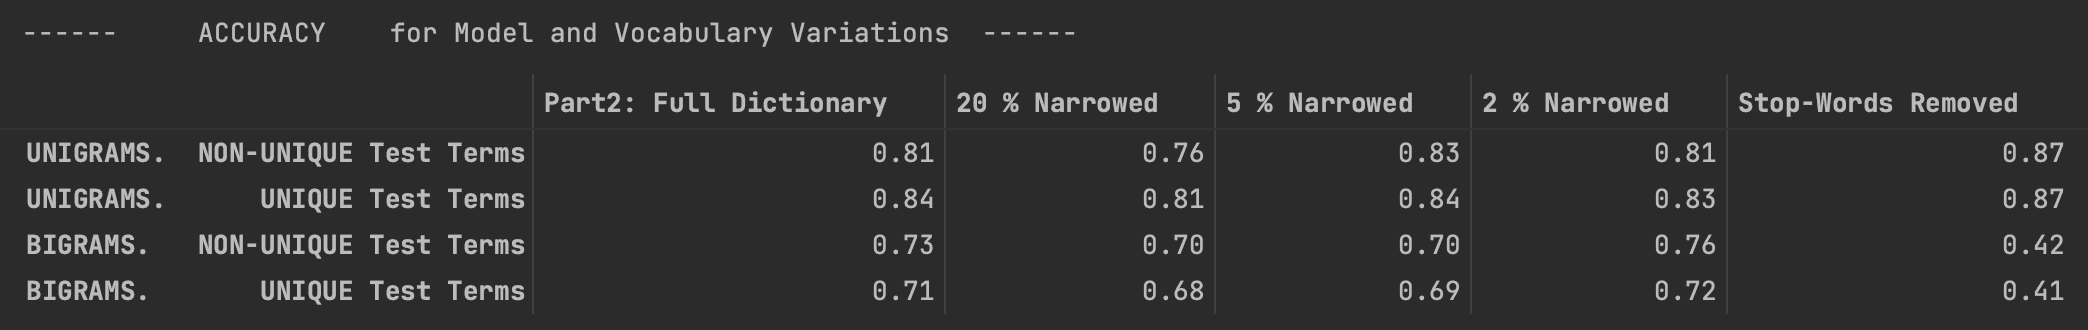

### Stop Words

The best Vocabulary Model is the Stop-Words Removed Unigram vocabularies, with 87 % Accuracy.
Assuming stop words generally reduce performance; we could guess that,
for Unigram Dictionaries, stop-words constitutes around 5 to 10 % of the vocabulary.
for Bigram Dictionaries,  stop-words are included in more than 25% of the vocabulary.
<br/>

### Reduce Test Samples to Unique terms or Not ?

NON-UNIQUE: Looping over (calculating and summing up) Probability for EACH Term in Test sample one-by-one.
This way, a Term appears more frequently has more affect than another one that appears once.
As seen in results, this is not advantageous, since Unique words can be better classifiers than frequent ones.

UNIQUE: Looping over not EACH but Each UNIQUE Term in Test sample.
This approach generally has at least 2 % more Accuracy advantage in Unigram Dictionaries.
Yet, for Bigram Vocabularies, it is the opposite.
<br/>

### How much Narrowing-Down the Vocabularies (removing TF-IDF-wise insignificant terms from Dictionaries) ?

We would like to see if removing non-category-relevant terms from dictionaries can reduce overfitting and errors, and improve performance.
Both for Unigram and Bigram Vocabularies, narrowing down by 20 % too much, we lost useful terms too, since all accuracies are observed to be decreased.

As it is observed, narrowing-down by 5%  increased accuracies of Unigram models by around 2%, whereas it decreased accuracies of Bigram models by around 2%.
We can safely say that, around 5% of the old vocabulary Unigrams were insignificant/non-useful (and in fact overfitting) for classification.
Yet, for Bigrams, we still seem to be eliminating too many. We should not have seen a decrease in accuracy.

Compared to 5% narrowed version, Accuracies of Unigram models are decreased by around 1%, yet Bigram has increased around 4%.
It seems that, only around 2% of Bigram vocabulary is insignificant/overfitting, not as much as 5%.
For Unigram Vocabulary, we observed that, definitely more than 2%, around 5%, definitely less than 20% of the Unigram vocabulary is insignificant.

<br/>

### Unigram vs Bigram:

Before the experiments, we would expect bigrams (word pairs) to perform better than unigrams (individual words) since
for example "best actress" or "digital cameras" are more specific classifiers in our daily language than "best" "actress" "digital" "cameras".
Yet our experiment results has shown higher accuracies in Unigram models.
Reason could be that, since our dataset is small, Bigrams were too unique for each article, an article could not have enough common bigrams with another article in the same category.
<br/>

### Why only 87% Accuracy ? :

In our previous experiments with KNN and Decision Tree algorithms, we could see accuracies around 90-95%. In this Naive Bayes experiment we could see max 85% accuracy with the best model. We of course could have made errors while constructing algorithms; the dataset could also contain errors and outliers; yet we believe even though Naive Bayes is a very fast algorithm, it is not very accurate. Reason is that, it only depends on the past, and heuristically guesses if similar events will happen in the future. The actual issue with that is, Naive Bayes assumes "conditional independence" and "equal chance"; it does not consider that events such as some words appearing together (not necessarily adjacent) in an article can be depending on each other, it does not consider that presence of some words might be more important than others.


#### This is the end of our report.